# CatBoost

In [2]:
%pip install shap lightgbm catboost optuna optuna.integration

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.6/538.6 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 28.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 21.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 746.5/746.5 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 606.0/606.0 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 MB 29.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import the libraries you'll need
import shap
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import optuna
from optuna.integration import OptunaSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# df = pd.read_excel("E:/Je respire/解析/1. 脳血流と問題カテゴリの関連.xlsx", sheet_name="ディアビアイ")
df = pd.read_excel("/root/workspace/1.2 脳血流と問題カテゴリの関連 - 背外側追加.xlsx", sheet_name="ディアビアイ")


In [3]:
df = df.drop(columns=['subject', 'question', 'q_category', #前半部分
                   'dataset_no', 'sheet_name']) # 後半部分

# df = df.iloc[24:246, :]  

In [4]:
# 脳血流のオキシヘモグロビンだけ使う場合
df = df.drop(columns=['CH1.1_std', 'CH2.1_std', 'CH3.1_std',
       'CH4.1_std', 'CH5.1_std', 'CH6.1_std', 'CH7.1_std', 'CH8.1_std',
       'CH9.1_std', 'CH10.1_std', 'CH11.1_std', 'CH12.1_std', 'CH13.1_std',
       'CH14.1_std', 'CH15.1_std', 'CH16.1_std', 'CH17.1_std', 'CH18.1_std',
       'CH19.1_std', 'CH20.1_std', 'CH21.1_std', 'CH22.1_std', 'CH1.2_std',
       'CH2.2_std', 'CH3.2_std', 'CH4.2_std', 'CH5.2_std', 'CH6.2_std',
       'CH7.2_std', 'CH8.2_std', 'CH9.2_std', 'CH10.2_std', 'CH11.2_std',
       'CH12.2_std', 'CH13.2_std', 'CH14.2_std', 'CH15.2_std', 'CH16.2_std',
       'CH17.2_std', 'CH18.2_std', 'CH19.2_std', 'CH20.2_std', 'CH21.2_std',
       'CH22.2_std' ]) # 後半部分

df = df.drop(columns=['right_pupil_std', 'CH1_std', 'CH2_std',
       'CH3_std', 'CH4_std', 'CH5_std', 'CH6_std', 'CH7_std', 'CH8_std',
       'CH9_std', 'CH10_std', 'CH11_std', 'CH12_std',
       'CH13_std', 'CH14_std', 'CH15_std', 'CH16_std', 'CH17_std',
       'CH18_std', 'CH19_std', 'CH20_std', 'CH21_std',
       'CH22_std']) # 主要な特徴量のみを残す場合


In [5]:
df['score'] = df['score'].replace(2, 1)

In [6]:
df.columns

Index(['score', 'left_pupil_std', 'right_haigai', 'hainai', 'left_haigai',
       'Sensor-E:SC/GSR_std', 'Sensor-G:BVP_std', '[G] BVP Amp._std',
       '[G] Heart Rate_std', '[G] HRV Amp._std',
       '[G] HRV-LF Power (0,04-0,16 Hz)_std',
       '[G] HRV-HF Power (0,16-0,4 Hz)_std', '[G] HRV-LF / HRV-HF _std'],
      dtype='object')

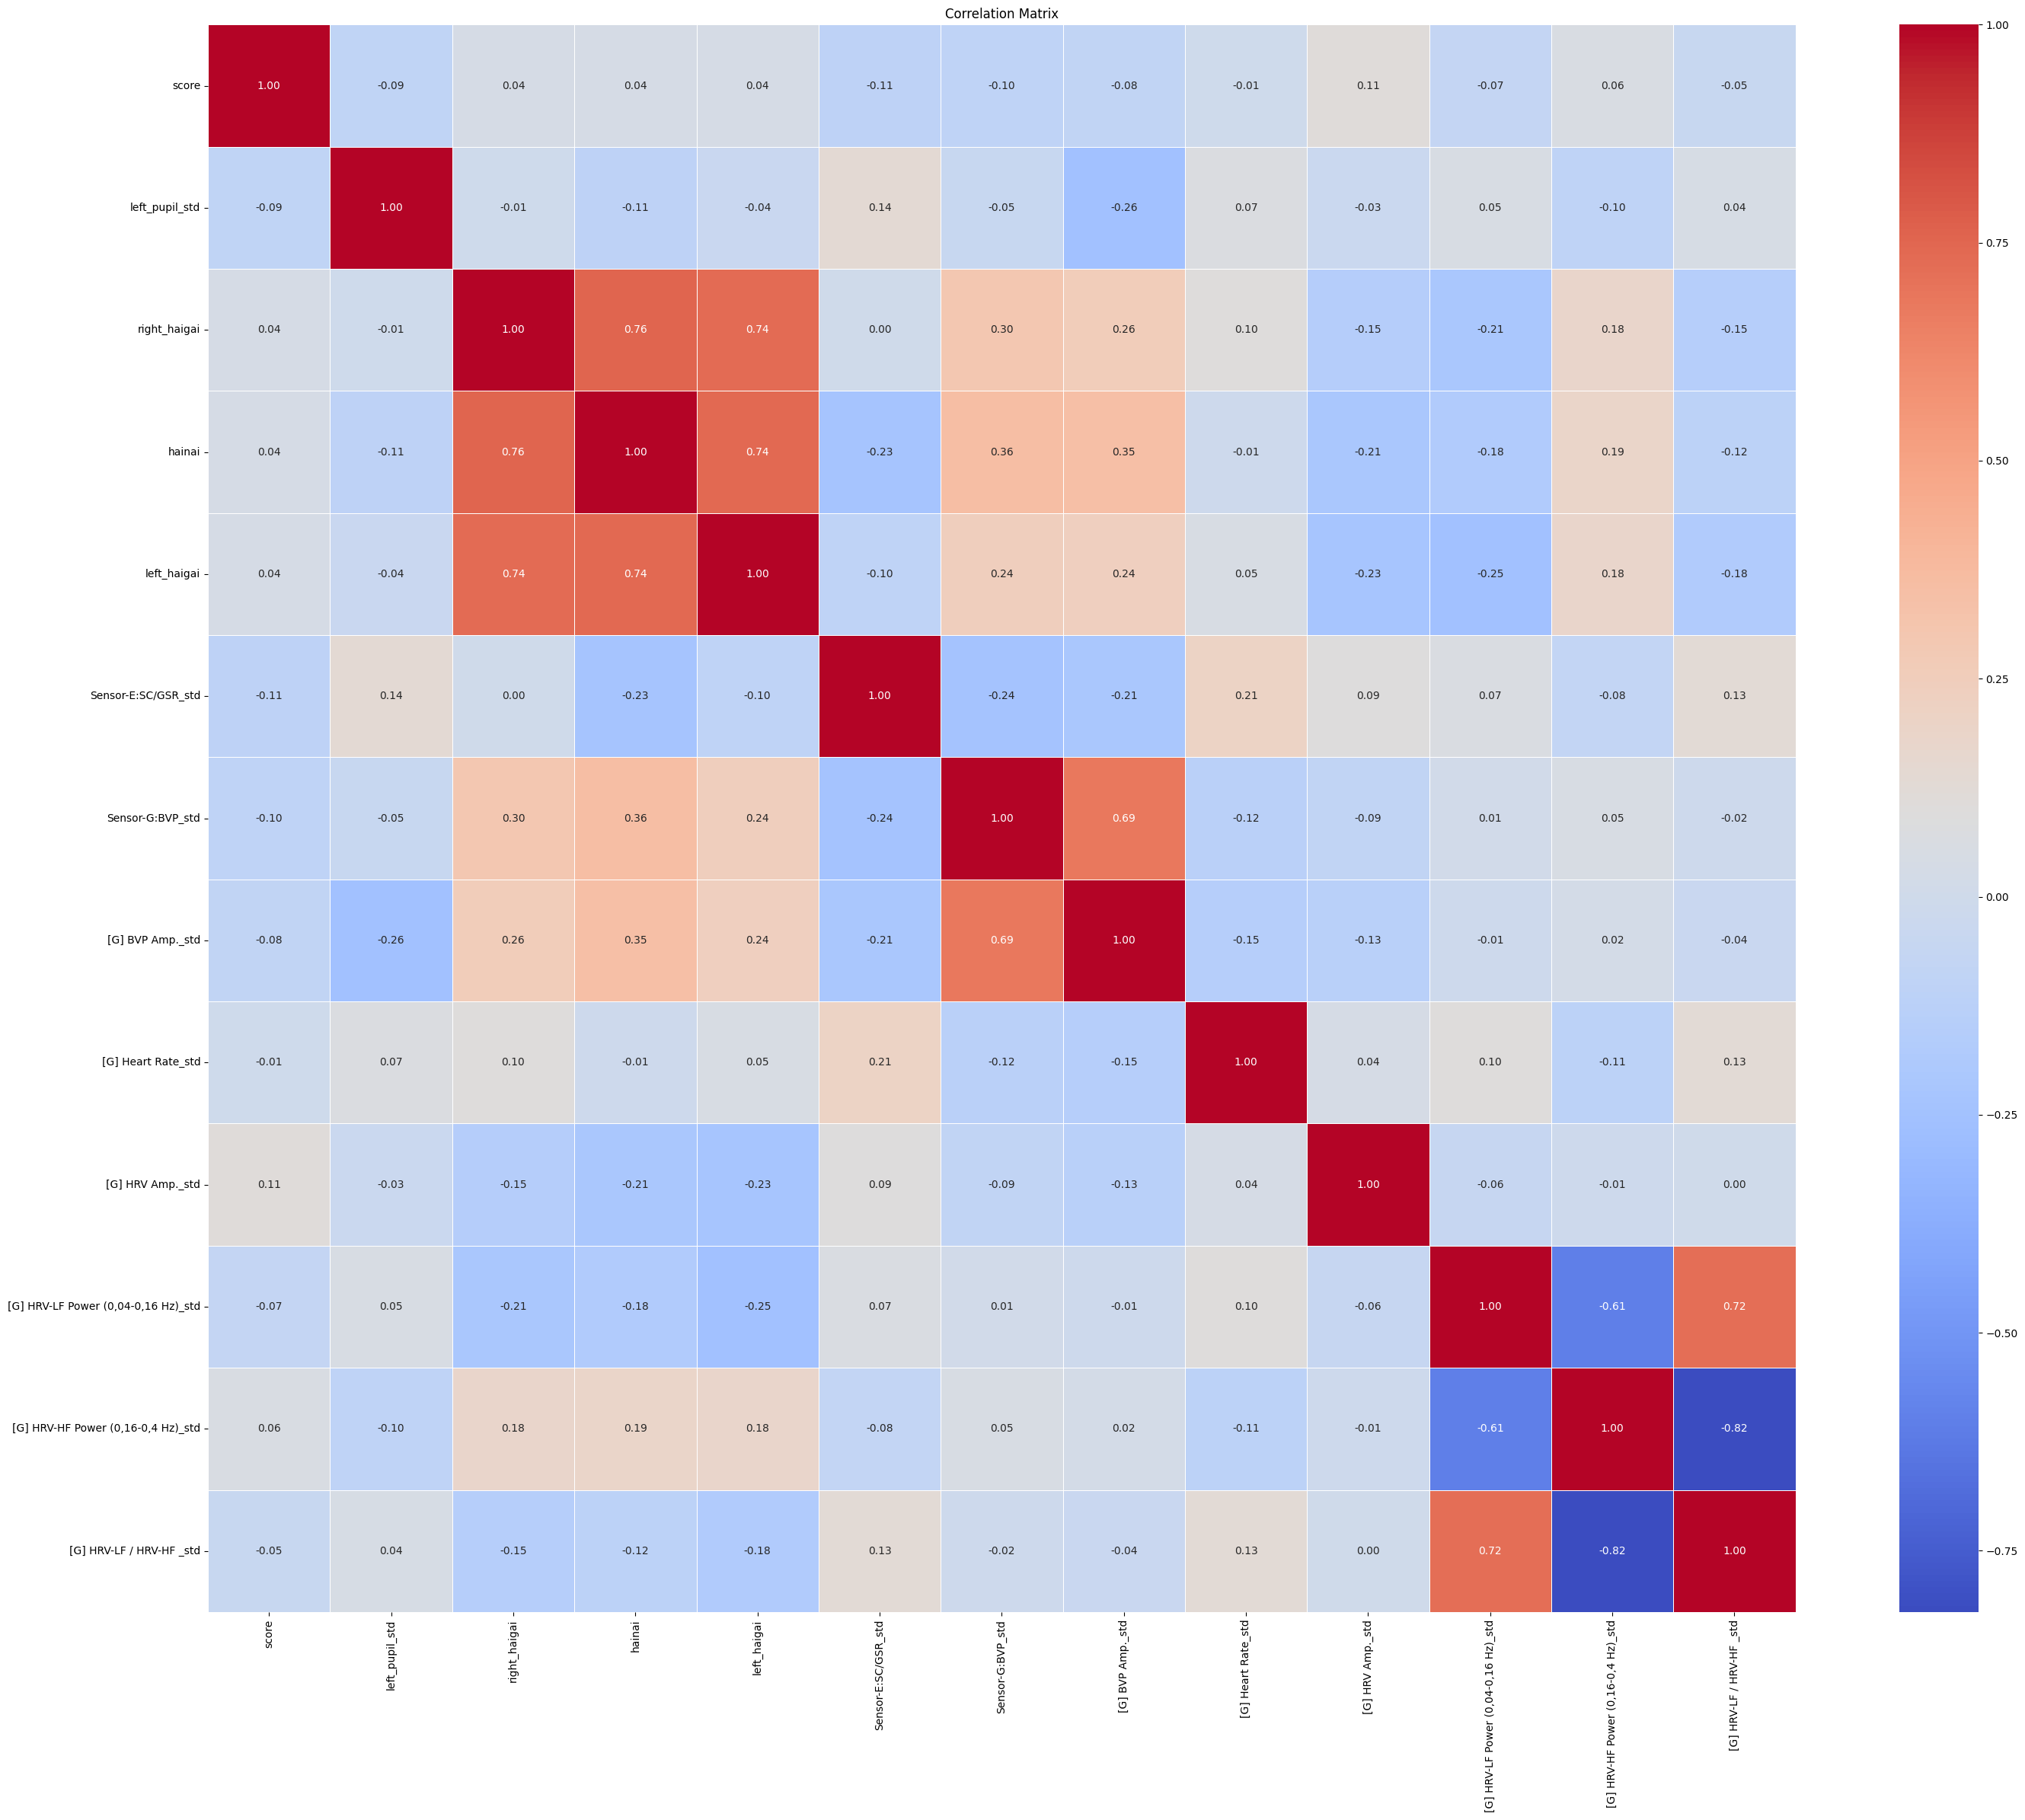

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 相関行列の計算
corr_matrix = df.corr(method='pearson')

# ヒートマップの描画
plt.figure(figsize=(30, 24))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


In [8]:
df.columns = [col.replace(':', '_')
                .replace('/', '_')
                .replace('[', '')
                .replace(']', '')
                .replace(' ', '_')
                .replace('.', '_')
                .replace(',', '_')
                .replace('(', '_')
                .replace(')', '_')
                for col in df.columns]

In [9]:
X = df.drop(columns=['score'])
y = df['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = CatBoostClassifier(random_state=42, verbose=0)
model.fit(X_train, y_train)



In [10]:
# param_dist = {
#     'n_estimators': optuna.distributions.FloatDistribution(50, 500),
#     'max_depth': optuna.distributions.FloatDistribution(2, 50),
#     'min_samples_split': optuna.distributions.FloatDistribution(2, 5),
#     'min_samples_leaf': optuna.distributions.FloatDistribution(2, 10),
#     'max_features': ['sqrt', 'log2']
# }

# Define hyperparameter search space
param_dist = {
    "iterations": optuna.distributions.IntDistribution(200, 1000),
    "depth": optuna.distributions.IntDistribution(3, 10),
    "learning_rate": optuna.distributions.FloatDistribution(1e-3, 0.3, log=True),
    "l2_leaf_reg": optuna.distributions.FloatDistribution(1, 10),
    "bagging_temperature": optuna.distributions.FloatDistribution(0, 1),
    "border_count": optuna.distributions.IntDistribution(32, 255),
}

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

optuna_search = OptunaSearchCV(
    model,
    param_dist,
    cv=cv, # 交差検証の設定
    n_trials=50, # トライアル回数
    scoring='accuracy', # 評価指標
    n_jobs=-1, # 計算するコアの数
    verbose=1
)

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.


In [11]:
optuna_search.fit(X_train, y_train) # モデルの学習
y_pred = optuna_search.predict(X_test) # テストデータに対する予測

[I 2025-10-31 03:54:35,506] A new study created in memory with name: no-name-3019a902-eb3b-4862-9860-2e66e3780377
[I 2025-10-31 03:54:37,329] Trial 3 finished with value: 0.625 and parameters: {'iterations': 285, 'depth': 5, 'learning_rate': 0.007657898345482056, 'l2_leaf_reg': 3.731956709916858, 'bagging_temperature': 0.6384140941852007, 'border_count': 107}. Best is trial 3 with value: 0.625.
[I 2025-10-31 03:54:37,740] Trial 4 finished with value: 0.5885416666666666 and parameters: {'iterations': 389, 'depth': 5, 'learning_rate': 0.042630152540901085, 'l2_leaf_reg': 7.473675927097242, 'bagging_temperature': 0.7487043616607486, 'border_count': 232}. Best is trial 3 with value: 0.625.
[I 2025-10-31 03:54:38,114] Trial 2 finished with value: 0.5989583333333333 and parameters: {'iterations': 613, 'depth': 4, 'learning_rate': 0.0790798791930823, 'l2_leaf_reg': 5.157960342400898, 'bagging_temperature': 0.5278682170011627, 'border_count': 67}. Best is trial 3 with value: 0.625.
[I 2025-10-

In [12]:
print("Best parameters: ", optuna_search.best_params_) # 最良のパラメータの表示
print("Test set accuracy: ", accuracy_score(y_test, y_pred)) # テストデータに対する予測精度の表示
print(accuracy_score(y_train, optuna_search.predict(X_train))) # 学習データに対する予測精度の表示

Best parameters:  {'iterations': 204, 'depth': 3, 'learning_rate': 0.002425550908299738, 'l2_leaf_reg': 6.546809684464966, 'bagging_temperature': 0.13556620827638863, 'border_count': 83}
Test set accuracy:  0.6666666666666666
0.671875


In [13]:
explainer = shap.TreeExplainer(model=optuna_search.best_estimator_)
shap_values = explainer.shap_values(X)
explanation = explainer(X)

In [14]:
print(explainer)
print(shap_values)
print(explanation)

[[ 0.00522837  0.02811749  0.00250642 ... -0.00137877  0.01463195
   0.02053916]
 [ 0.00479225  0.02812865  0.00552353 ... -0.00137877  0.01459975
   0.01981803]
 [-0.02047257  0.02540176  0.00537251 ... -0.00179564  0.01212804
   0.02002647]
 ...
 [-0.00045149 -0.00916939 -0.00223865 ... -0.03752446  0.00016333
  -0.02000116]
 [-0.00378011 -0.00404032 -0.00045979 ...  0.02575142  0.00072223
  -0.00757463]
 [-0.00741245 -0.00326665  0.00045229 ...  0.02118234  0.00166574
  -0.01038804]]
.values =
array([[ 0.00522837,  0.02811749,  0.00250642, ..., -0.00137877,
         0.01463195,  0.02053916],
       [ 0.00479225,  0.02812865,  0.00552353, ..., -0.00137877,
         0.01459975,  0.01981803],
       [-0.02047257,  0.02540176,  0.00537251, ..., -0.00179564,
         0.01212804,  0.02002647],
       ...,
       [-0.00045149, -0.00916939, -0.00223865, ..., -0.03752446,
         0.00016333, -0.02000116],
       [-0.00378011, -0.00404032, -0.00045979, ...,  0.02575142,
         0.00072223, 

In [15]:
shap_values.shape

(240, 12)

In [16]:
shap_values


array([[ 0.00522837,  0.02811749,  0.00250642, ..., -0.00137877,
         0.01463195,  0.02053916],
       [ 0.00479225,  0.02812865,  0.00552353, ..., -0.00137877,
         0.01459975,  0.01981803],
       [-0.02047257,  0.02540176,  0.00537251, ..., -0.00179564,
         0.01212804,  0.02002647],
       ...,
       [-0.00045149, -0.00916939, -0.00223865, ..., -0.03752446,
         0.00016333, -0.02000116],
       [-0.00378011, -0.00404032, -0.00045979, ...,  0.02575142,
         0.00072223, -0.00757463],
       [-0.00741245, -0.00326665,  0.00045229, ...,  0.02118234,
         0.00166574, -0.01038804]])

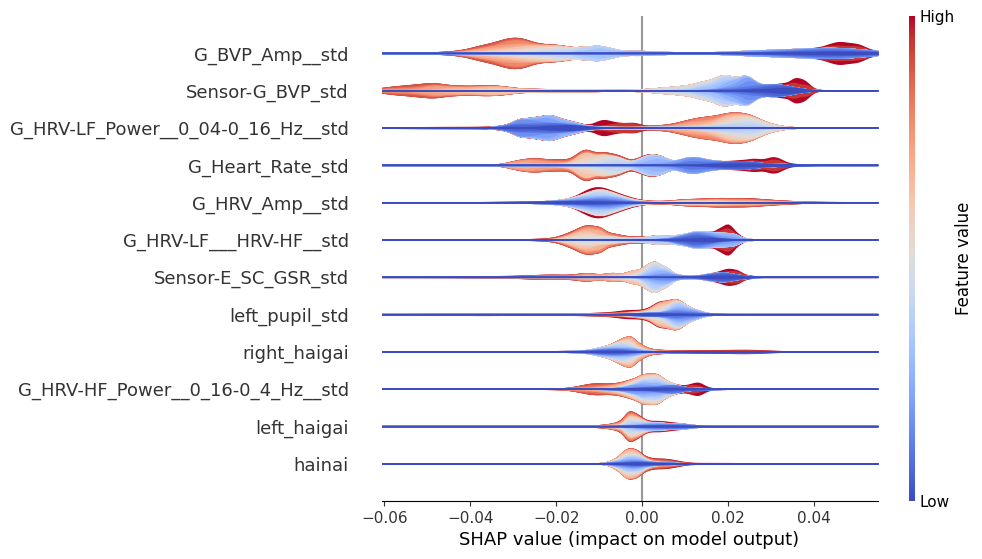

In [17]:
feat_names = list(X.columns)
shap.plots.violin(shap_values, features=X, feature_names=feat_names, plot_type="layered_violin")

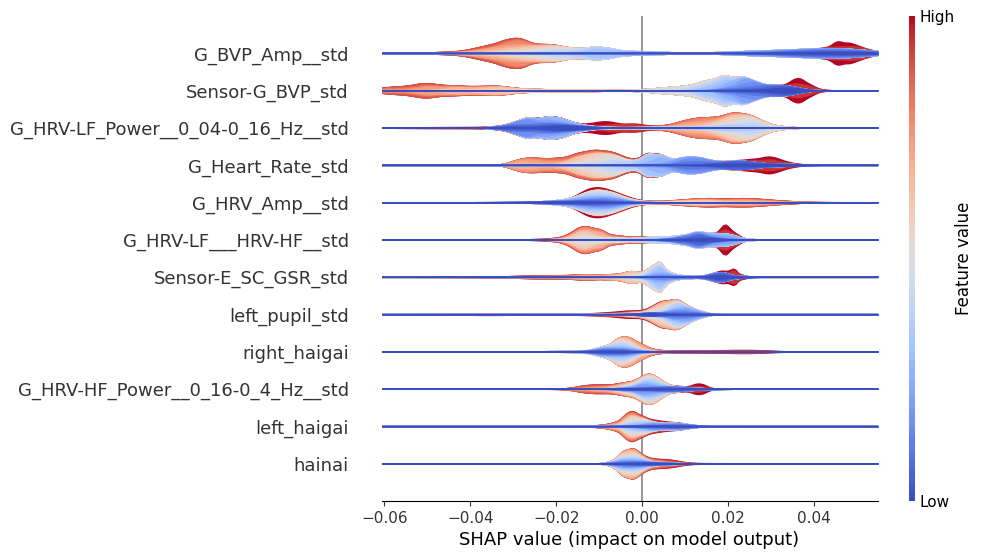

In [18]:
feat_names = list(X.columns)
shap.plots.violin(shap_values, features=X, feature_names=feat_names, plot_type="layered_violin")

In [19]:
print(X.columns)

Index(['left_pupil_std', 'right_haigai', 'hainai', 'left_haigai',
       'Sensor-E_SC_GSR_std', 'Sensor-G_BVP_std', 'G_BVP_Amp__std',
       'G_Heart_Rate_std', 'G_HRV_Amp__std',
       'G_HRV-LF_Power__0_04-0_16_Hz__std', 'G_HRV-HF_Power__0_16-0_4_Hz__std',
       'G_HRV-LF___HRV-HF__std'],
      dtype='object')


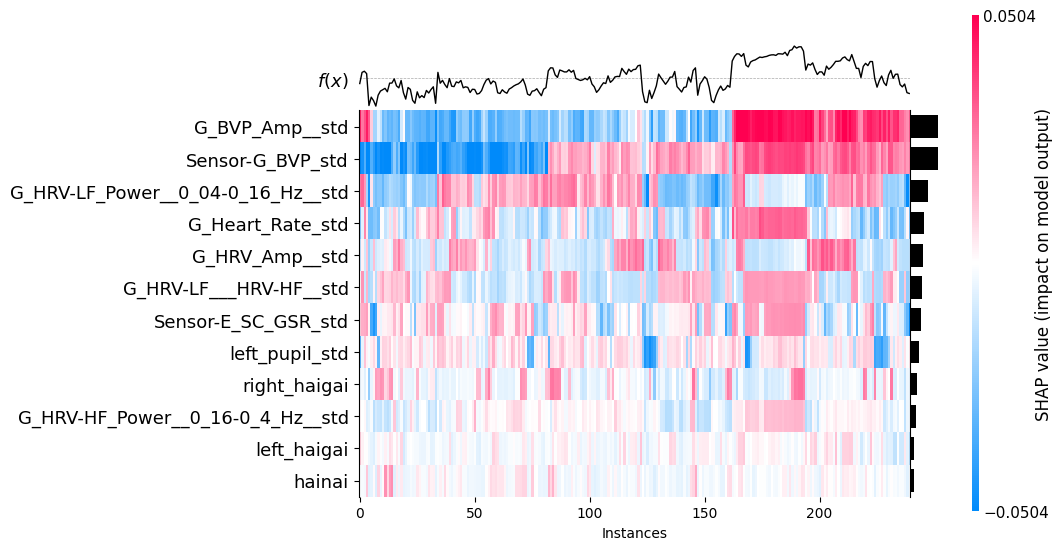

In [20]:
shap.plots.heatmap(explanation, max_display=12)

Index(['left_pupil_std', 'right_haigai', 'hainai', 'left_haigai',
       'Sensor-E_SC_GSR_std', 'Sensor-G_BVP_std', 'G_BVP_Amp__std',
       'G_Heart_Rate_std', 'G_HRV_Amp__std',
       'G_HRV-LF_Power__0_04-0_16_Hz__std', 'G_HRV-HF_Power__0_16-0_4_Hz__std',
       'G_HRV-LF___HRV-HF__std'],
      dtype='object')


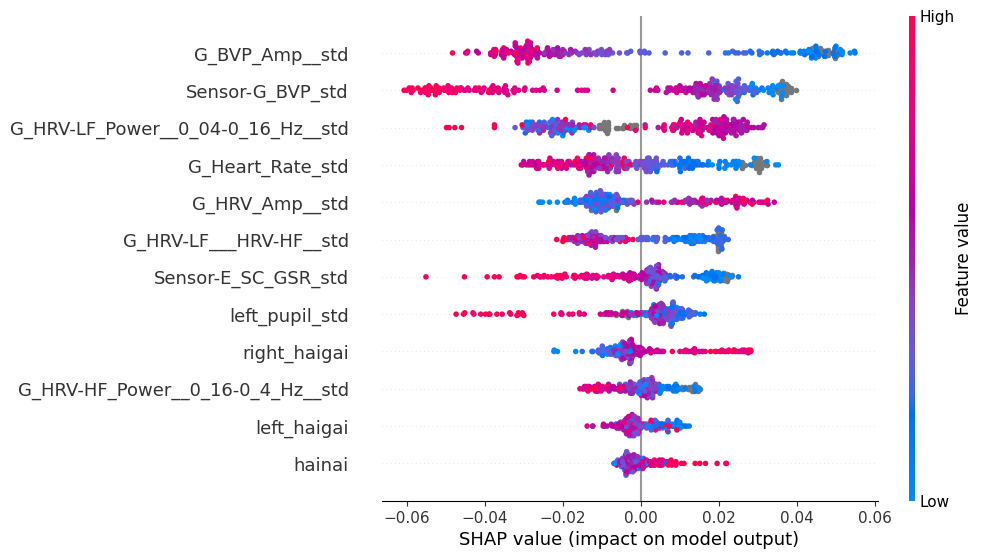

In [21]:
print(X.columns)
shap.plots.beeswarm(explanation, max_display=20)

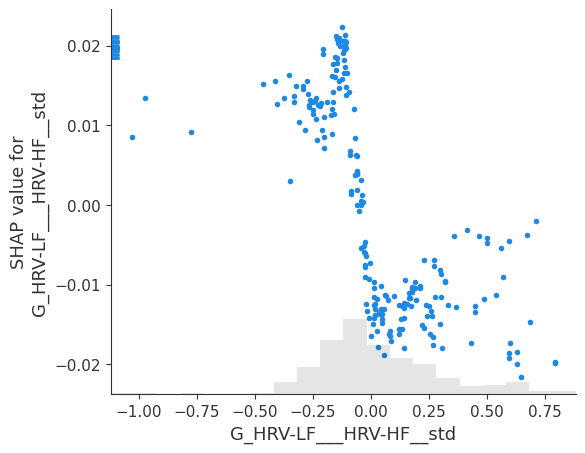

In [22]:
# shap.plots.scatter(explanation[:, "left_pupil_std", 1], color=explanation[:, "right_pupil_std", 1])
shap.plots.scatter(explanation[:,11])

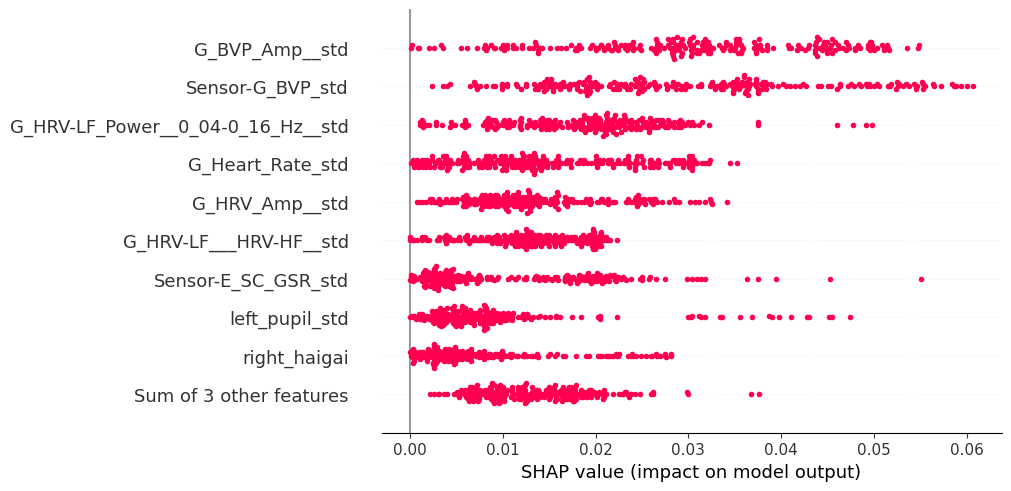

In [23]:
shap.plots.beeswarm(explanation.abs, color="shap_red")

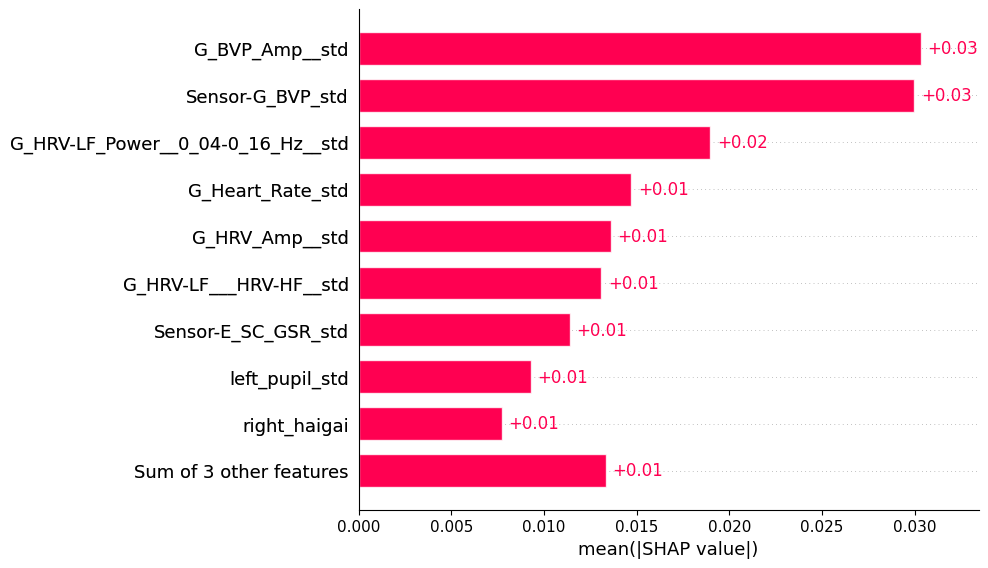

In [24]:
shap.plots.bar(explanation.abs.mean(0))

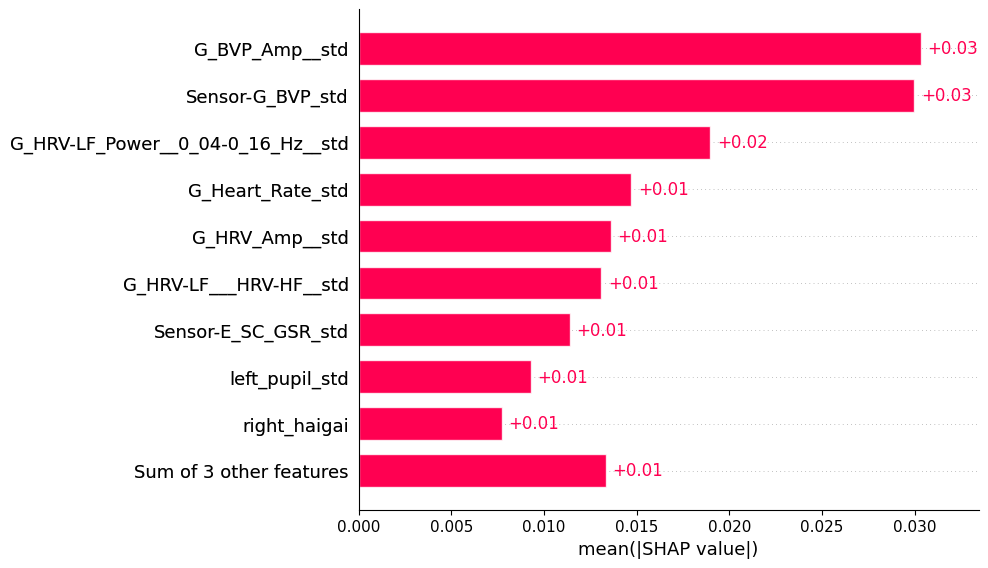

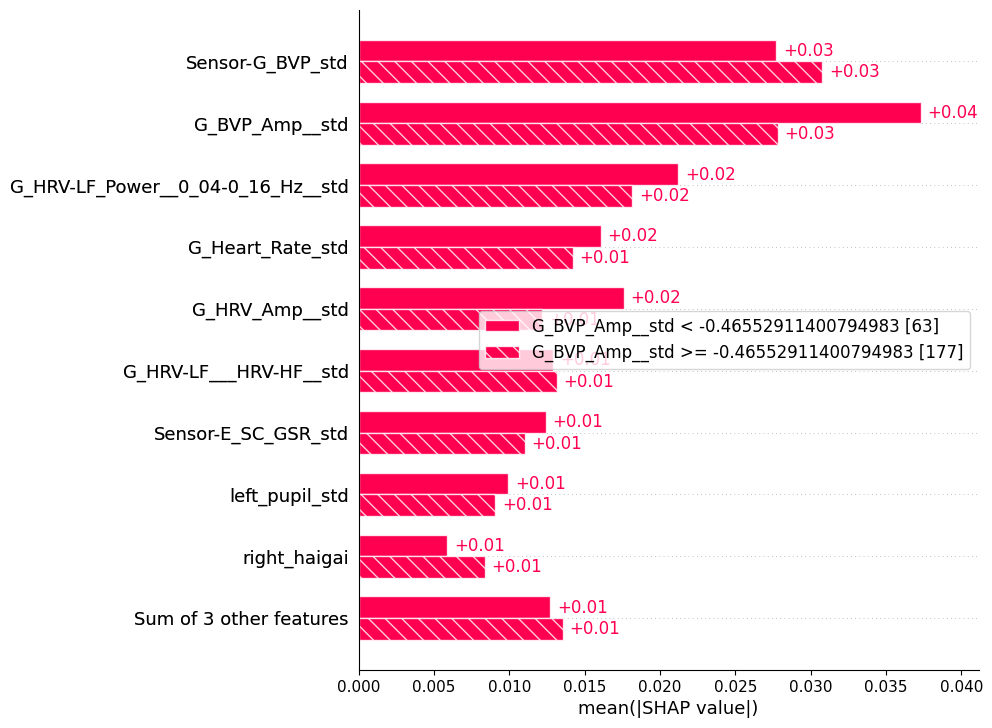

In [25]:
shap.plots.bar(explanation)
shap.plots.bar(explanation.cohorts(2).abs.mean(0))

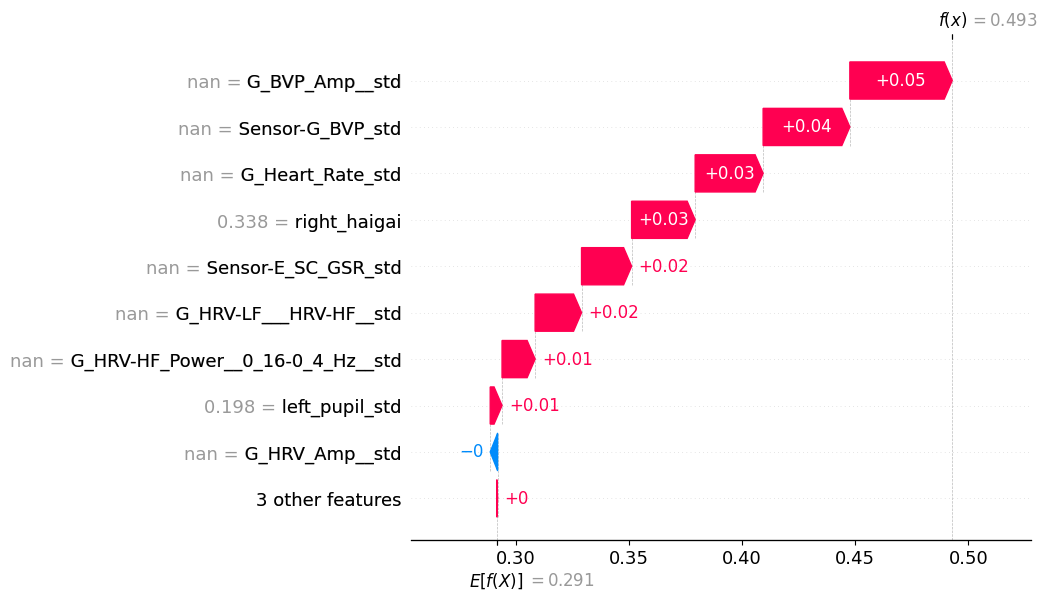

In [26]:
shap.plots.waterfall(explanation[0])

In [27]:
import json
import yaml
import pandas as pd
import numpy as np
from joblib import dump

from datetime import datetime

# 現在時刻を取得して、フォーマット
now = datetime.now()
timestamp = now.strftime('%Y%m%d_%H%M%S')



# 4. 保存処理
dump(model, f'C:/WorkSpace/共同研究/松島さん/Je respire ノーパソ/結果保存/model{timestamp}.joblib')  # モデル
with open(f'C:/WorkSpace/共同研究/松島さん/Je respire ノーパソ/結果保存/params{timestamp}.yaml', 'w') as f:
    yaml.dump(optuna_search.best_params_, f)     # ハイパーパラメータ
with open(f'C:/WorkSpace/共同研究/松島さん/Je respire ノーパソ/結果保存/metrics{timestamp}.json', 'w') as f:
    json.dump(accuracy_score(y_test, y_pred), f)    # 精度
pd.DataFrame(shap_values[1]).to_csv(f'C:/WorkSpace/共同研究/松島さん/Je respire ノーパソ/結果保存/shap_values{timestamp}.csv', index=False)  # SHAP値（クラス1）

# 5. オプション：SHAP explainerも保存
dump(explainer, f'C:/WorkSpace/共同研究/松島さん/Je respire ノーパソ/結果保存/shap_explainer{timestamp}.joblib')


FileNotFoundError: [Errno 2] No such file or directory: 'C:/WorkSpace/共同研究/松島さん/Je respire ノーパソ/結果保存/model20251031_035520.joblib'

# Gradient Boosting Decision Trees

In [ ]:
import optuna
from optuna.integration import OptunaSearchCV
import lightgbm as lgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split